# **TMDB MOVIE DATA ANALYSIS USING PYSPARK**

This project extracts movie data from the TMDB API, cleans and preprocesses the dataset, and performs in-depth exploratory data analysis. The goal is to uncover meaningful insights, identify trends, and support data-driven decision-making based on movie performance, audience behavior, and industry patterns.

## **IMPORTS LIBRARIES**

In [1]:
#Import os and sys
import os
import sys 
from pathlib import Path

#Spark imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

sys.path

#Imports loadEnv from config module
from config.config import loadEnv, getURL, create_retry

#Imports the raw data schema
from src.schemas.raw_data_schema import raw_movie_schema
from src.schemas.cleaned_movie_schema import cleaned_movie_schema

#Imports extractDataFromAPI from the extract data module
from Data_Extraction.extractData import extractDataFromAPI

#Data cleaning and preprocessing import
from src.preprocessing.preprocessing import preprocessing

#KPI functions import
from src.kpis.performance_kpis import movie_performance_kpis
from src.kpis.search_kpis import advanced_movie_search_kpis
from src.kpis.franchise_standalone_kpis import franchise_vs_standalone_kpis
from src.kpis.franchise_director_kpis import franchise_success_kpis
from src.kpis.director_kpis import director_success_kpis

#Data Visualization import
from src.visualization.dataVisualization import trendVisuals, plot_yearly_box_office_trends, plot_franchise_vs_standalone_metrics, plot_roi_by_genre

## **PYSPARK CONFIGUARTION**

In [2]:
"""
    Adaptive Query Execution (AQE): Dynamically optimizes query plans at runtime
    Coalesce Partitions: Reduces number of partitions for small datasets automatically

"""
spark = (
    SparkSession.builder
    .appName("TMDB Movie Data Analysis")
    .master("local[*]")
    .config("spark.sql.adaptive.enabled", "true") 
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
    .getOrCreate()
)

# Set display options for better debugging
#Eager Eval: Shows DataFrames nicely in notebooks (like Pandas)
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 10)

print("Spark Session Configured Sucessfully")


Spark Session Configured Sucessfully


## **DATA EXTRACTION**

In [3]:
"""

movie_ids = [0, 299534,19995,140607,299536,597,135397, 420818, 24428, 168259, 99861,
                    284054, 12445, 181808, 330457, 351286, 109445, 321612, 260513] 

API_KEY = loadEnv(fileName="API_KEY")

url = getURL()

session = create_retry()

extractDataFromAPI(session = session, url = url, API_KEY = API_KEY, movie_ids=movie_ids)

"""


'\n\nmovie_ids = [0, 299534,19995,140607,299536,597,135397, 420818, 24428, 168259, 99861,\n                    284054, 12445, 181808, 330457, 351286, 109445, 321612, 260513] \n\nAPI_KEY = loadEnv(fileName="API_KEY")\n\nurl = getURL()\n\nsession = create_retry()\n\nextractDataFromAPI(session = session, url = url, API_KEY = API_KEY, movie_ids=movie_ids)\n\n'

## **EXPLORATORY DATA ANALYSIS**

### **READS THE CSV FILE**

In [4]:
#Reads the csv file
movie_data = (
    spark.read
    .schema(raw_movie_schema())
    .json("/data/raw_data/movieData.json")
)


### **INSPECTS DATA**

In [5]:
# Verifies the data is loaded
print("Initial Data Overview \n")
print(f"Total Records: {movie_data.count()}")
print(f"Total Columns: {len(movie_data.columns)}")

# Show sample data (first 3 rows, non-truncated for key columns)
movie_data.select("id", "title", "release_date", "genres").show(3, truncate=60)

Initial Data Overview 

Total Records: 18
Total Columns: 27
+------+----------------------------+------------+------------------------------------------------------------+
|    id|                       title|release_date|                                                      genres|
+------+----------------------------+------------+------------------------------------------------------------+
|299534|           Avengers: Endgame|  2019-04-24|     [{12, Adventure}, {878, Science Fiction}, {28, Action}]|
| 19995|                      Avatar|  2009-12-16|[{28, Action}, {12, Adventure}, {14, Fantasy}, {878, Scie...|
|140607|Star Wars: The Force Awakens|  2015-12-15|     [{12, Adventure}, {28, Action}, {878, Science Fiction}]|
+------+----------------------------+------------+------------------------------------------------------------+
only showing top 3 rows



### **OUTPUTS THE COLUMNS IN THE DATAFRAME**

In [6]:
if movie_data is None or movie_data.rdd.isEmpty():
    print("No data extracted from the API")
else:
    movie_data.printSchema()


root
 |-- adult: boolean (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- belongs_to_collection: struct (nullable = true)
 |    |-- backdrop_path: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- poster_path: string (nullable = true)
 |-- budget: long (nullable = true)
 |-- credits: struct (nullable = true)
 |    |-- cast: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- adult: boolean (nullable = true)
 |    |    |    |-- cast_id: long (nullable = true)
 |    |    |    |-- character: string (nullable = true)
 |    |    |    |-- credit_id: string (nullable = true)
 |    |    |    |-- gender: long (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- known_for_department: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- order: long (nullable = true)
 |    |    |    |-- original_nam

In [7]:
#Outputs the first five rows in the data
movie_data.show(5)

+-----+--------------------+---------------------+---------+--------------------+--------------------+--------------------+------+---------+--------------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+--------------------+-----+------------+----------+
|adult|       backdrop_path|belongs_to_collection|   budget|             credits|              genres|            homepage|    id|  imdb_id|origin_country|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|   revenue|runtime|    spoken_languages|  status|             tagline|               title|video|vote_average|vote_count|
+-----+--------------------+---------------------+---------+--------------------+--------------------+--------------------+------+---------+------------

## **DATA CLEANING AND PREPARATION**

### **CALLS THE PREPROCESSING SCRIPT TO CLEAN THE RAW MOVIE DATA**

In [8]:
#Calls the preprocessing script
cleaned_movie_data_path = preprocessing(spark=spark, filepath="/data/raw_data/movieData.json")

2026-01-29 08:59:13,020 - preprocessing - INFO - ========== STARTING DATA PREPROCESSING ==========


2026-01-29 08:59:13,123 - preprocessing - INFO - Data loaded from /data/raw_data/movieData.json
2026-01-29 08:59:13,366 - preprocessing - INFO - Initial row count: 18
2026-01-29 08:59:13,396 - preprocessing - INFO - Dropped irrelevant columns: ['adult', 'backdrop_path', 'origin_country', 'original_title', 'imdb_id', 'video', 'homepage']
2026-01-29 08:59:13,625 - preprocessing - INFO - Parsed array-based columns successfully.
2026-01-29 08:59:13,818 - preprocessing - INFO - Extracted director, cast, crew_size, cast_size.
2026-01-29 08:59:14,059 - preprocessing - INFO - Converted datatypes and scaled budget/revenue.
2026-01-29 08:59:14,295 - preprocessing - INFO - Handled unrealistic values and placeholders.
2026-01-29 08:59:15,442 - preprocessing - INFO - Row count after deduplication: 18
2026-01-29 08:59:17,050 - preprocessing - INFO - Row count after non-null filtering: 18
2026-01-29 08:59:17,724 - preprocessing - INFO - Row count after Released filter: 18
2026-01-29 08:59:17,791 - pr

### **READS THE CLEANED MOVIE DATA TO ANALYZE IT**

In [9]:
#Reads the parquet file
cleaned_data = (
    spark.read
    .schema(cleaned_movie_schema())
    .parquet(cleaned_movie_data_path)
)


In [10]:
#Prints the schema of the cleaned data
cleaned_data.printSchema()

root
 |-- id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- genres: string (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- budget_musd: double (nullable = true)
 |-- revenue_musd: double (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- vote_count: long (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- runtime: double (nullable = true)
 |-- overview: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- cast_size: integer (nullable = true)
 |-- director: string (nullable = true)
 |-- crew_size: integer (nullable = true)



In [11]:
#Outputs the cleaned data
cleaned_data.show(truncate=False)

+------+--------------------------------------------+--------------------------------------------------------------------------+------------+-----------------------------------------+-----------------------------------+-----------------+-----------+------------+------------------------------------------------------------------------------------+---------------------------------------+----------+------------+----------+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------

## **KPI IMPLEMENTATION AND ANALYSIS**

### **CALLS THE MOVIE PERFORMANCE KPIs**

In [12]:
#Calls the movie performance kpis function
performance_kpis = movie_performance_kpis(cleaned_data)

2026-01-29 08:59:21,792 - movie_performance_kpis - INFO - Starting Movie Performance KPIs computation
2026-01-29 08:59:21,794 - movie_performance_kpis - INFO - Adding derived columns: profit and ROI


2026-01-29 08:59:21,862 - movie_performance_kpis - INFO - Computing revenue and budget rankings
2026-01-29 08:59:21,897 - movie_performance_kpis - INFO - Computing profit-based KPIs
2026-01-29 08:59:21,922 - movie_performance_kpis - INFO - Computing ROI-based KPIs (budget >= 10M)
2026-01-29 08:59:21,956 - movie_performance_kpis - INFO - Computing votes and ratings KPIs
2026-01-29 08:59:22,002 - movie_performance_kpis - INFO - Computing popularity KPI
2026-01-29 08:59:22,014 - movie_performance_kpis - INFO - Movie Performance KPIs completed in 0.22 seconds


### **HIGHEST REVENUE**

In [13]:
#Ranks the revenue from highest to lowest
performance_kpis["highest_revenue"].select("title", "revenue_musd").show()


+--------------------+------------+
|               title|revenue_musd|
+--------------------+------------+
|              Avatar|     2923.71|
|   Avengers: Endgame|     2799.44|
|             Titanic|     2264.16|
|Star Wars: The Fo...|     2068.22|
|Avengers: Infinit...|     2052.42|
|      Jurassic World|     1671.54|
|       The Lion King|     1662.02|
|        The Avengers|     1518.82|
|           Furious 7|      1515.4|
|           Frozen II|     1453.68|
|Avengers: Age of ...|      1405.4|
|       Black Panther|     1349.93|
|Harry Potter and ...|     1341.51|
|Star Wars: The La...|      1332.7|
|Jurassic World: F...|     1310.47|
|              Frozen|     1274.22|
|Beauty and the Beast|     1266.12|
|       Incredibles 2|     1243.23|
+--------------------+------------+



### **HIGHEST BUDGET**

In [14]:
#Ranks the movies based on roi
performance_kpis["highest_budget"].select("title", "budget_musd").show(truncate=False)


+--------------------------------------------+-----------+
|title                                       |budget_musd|
+--------------------------------------------+-----------+
|Avengers: Endgame                           |356.0      |
|Star Wars: The Last Jedi                    |300.0      |
|Avengers: Infinity War                      |300.0      |
|The Lion King                               |260.0      |
|Star Wars: The Force Awakens                |245.0      |
|Avatar                                      |237.0      |
|Avengers: Age of Ultron                     |235.0      |
|The Avengers                                |220.0      |
|Titanic                                     |200.0      |
|Incredibles 2                               |200.0      |
|Black Panther                               |200.0      |
|Furious 7                                   |190.0      |
|Jurassic World: Fallen Kingdom              |170.0      |
|Beauty and the Beast                        |160.0     

### **HIGHEST PROFIT**

In [15]:
#Ranks the movies based on profit
performance_kpis["highest_profit"].select("title", "profit").show(truncate=False)


+--------------------------------------------+-------+
|title                                       |profit |
+--------------------------------------------+-------+
|Avatar                                      |2686.71|
|Avengers: Endgame                           |2443.44|
|Titanic                                     |2064.16|
|Star Wars: The Force Awakens                |1823.22|
|Avengers: Infinity War                      |1752.42|
|Jurassic World                              |1521.54|
|The Lion King                               |1402.02|
|Furious 7                                   |1325.4 |
|Frozen II                                   |1303.68|
|The Avengers                                |1298.82|
|Harry Potter and the Deathly Hallows: Part 2|1216.51|
|Avengers: Age of Ultron                     |1170.4 |
|Black Panther                               |1149.93|
|Jurassic World: Fallen Kingdom              |1140.47|
|Frozen                                      |1124.22|
|Beauty an

### **LOWEST PROFIT**

In [16]:
#Ranks the movies based on profit
performance_kpis["lowest_profit"].select("title", "profit").show(truncate=False)


+--------------------------------------------+-------+
|title                                       |profit |
+--------------------------------------------+-------+
|Star Wars: The Last Jedi                    |1032.7 |
|Incredibles 2                               |1043.23|
|Beauty and the Beast                        |1106.12|
|Frozen                                      |1124.22|
|Jurassic World: Fallen Kingdom              |1140.47|
|Black Panther                               |1149.93|
|Avengers: Age of Ultron                     |1170.4 |
|Harry Potter and the Deathly Hallows: Part 2|1216.51|
|The Avengers                                |1298.82|
|Frozen II                                   |1303.68|
|Furious 7                                   |1325.4 |
|The Lion King                               |1402.02|
|Jurassic World                              |1521.54|
|Avengers: Infinity War                      |1752.42|
|Star Wars: The Force Awakens                |1823.22|
|Titanic  

### **HIGHEST ROI**

In [17]:
#Ranks the movies based on the ROI column
performance_kpis["highest_roi"].select("title", "roi").show(truncate=False)


+--------------------------------------------+-----+
|title                                       |roi  |
+--------------------------------------------+-----+
|Avatar                                      |12.34|
|Titanic                                     |11.32|
|Jurassic World                              |11.14|
|Harry Potter and the Deathly Hallows: Part 2|10.73|
|Frozen II                                   |9.69 |
|Frozen                                      |8.49 |
|Star Wars: The Force Awakens                |8.44 |
|Furious 7                                   |7.98 |
|Beauty and the Beast                        |7.91 |
|Avengers: Endgame                           |7.86 |
|Jurassic World: Fallen Kingdom              |7.71 |
|The Avengers                                |6.9  |
|Avengers: Infinity War                      |6.84 |
|Black Panther                               |6.75 |
|The Lion King                               |6.39 |
|Incredibles 2                               |

### **LOWEST ROI**

In [18]:
#Ranks the movies based on the ROI column
performance_kpis["lowest_roi"].select("title", "roi").show(truncate=False)


+--------------------------------------------+-----+
|title                                       |roi  |
+--------------------------------------------+-----+
|Star Wars: The Last Jedi                    |4.44 |
|Avengers: Age of Ultron                     |5.98 |
|Incredibles 2                               |6.22 |
|The Lion King                               |6.39 |
|Black Panther                               |6.75 |
|Avengers: Infinity War                      |6.84 |
|The Avengers                                |6.9  |
|Jurassic World: Fallen Kingdom              |7.71 |
|Avengers: Endgame                           |7.86 |
|Beauty and the Beast                        |7.91 |
|Furious 7                                   |7.98 |
|Star Wars: The Force Awakens                |8.44 |
|Frozen                                      |8.49 |
|Frozen II                                   |9.69 |
|Harry Potter and the Deathly Hallows: Part 2|10.73|
|Jurassic World                              |

### **MOST VOTED MOVIES**

In [19]:
#Ranks movies based on votes
performance_kpis["most_voted"].select("title", "vote_count").show(truncate=False)


+--------------------------------------------+----------+
|title                                       |vote_count|
+--------------------------------------------+----------+
|The Avengers                                |35437     |
|Avatar                                      |33340     |
|Avengers: Infinity War                      |31392     |
|Avengers: Endgame                           |27178     |
|Titanic                                     |26704     |
|Avengers: Age of Ultron                     |24055     |
|Black Panther                               |23111     |
|Harry Potter and the Deathly Hallows: Part 2|21613     |
|Jurassic World                              |21264     |
|Star Wars: The Force Awakens                |20233     |
|Frozen                                      |17303     |
|Star Wars: The Last Jedi                    |16048     |
|Beauty and the Beast                        |15886     |
|Incredibles 2                               |13463     |
|Jurassic Worl

### **HIGHEST RATED MOVIES**

In [20]:
#Ranks the highest rated movies (movies with vote count >= 10)
performance_kpis["highest_rated"].select("title", "vote_count", "vote_average").show(truncate=False)


+--------------------------------------------+----------+------------+
|title                                       |vote_count|vote_average|
+--------------------------------------------+----------+------------+
|Avengers: Endgame                           |27178     |8.236       |
|Avengers: Infinity War                      |31392     |8.234       |
|Harry Potter and the Deathly Hallows: Part 2|21613     |8.081       |
|The Avengers                                |35437     |7.921       |
|Titanic                                     |26704     |7.9         |
|Avatar                                      |33340     |7.6         |
|Incredibles 2                               |13463     |7.453       |
|Black Panther                               |23111     |7.363       |
|Avengers: Age of Ultron                     |24055     |7.27        |
|Star Wars: The Force Awakens                |20233     |7.252       |
|Frozen                                      |17303     |7.248       |
|Froze

### **LOWEST RATED MOVIES**

In [21]:
#Ranks the lowest rated movies (movies with vote count >= 10)
performance_kpis["lowest_rated"].select("title", "vote_count", "vote_average").show(truncate=False)


+--------------------------------------------+----------+------------+
|title                                       |vote_count|vote_average|
+--------------------------------------------+----------+------------+
|Jurassic World: Fallen Kingdom              |12511     |6.534       |
|Jurassic World                              |21264     |6.699       |
|Star Wars: The Last Jedi                    |16048     |6.76        |
|Beauty and the Beast                        |15886     |6.968       |
|The Lion King                               |10618     |7.097       |
|Furious 7                                   |11107     |7.218       |
|Frozen II                                   |10129     |7.237       |
|Frozen                                      |17303     |7.248       |
|Star Wars: The Force Awakens                |20233     |7.252       |
|Avengers: Age of Ultron                     |24055     |7.27        |
|Black Panther                               |23111     |7.363       |
|Incre

### **MOST POPULAR MOVIES**

In [22]:
#Ranks the movies based on popularity
performance_kpis["most_popular"].select("title", "popularity", "profit").show(truncate=False)


+--------------------------------------------+----------+-------+
|title                                       |popularity|profit |
+--------------------------------------------+----------+-------+
|The Avengers                                |69.8586   |1298.82|
|Avatar                                      |46.448    |2686.71|
|Titanic                                     |30.3112   |2064.16|
|Avengers: Infinity War                      |29.6327   |1752.42|
|Frozen                                      |19.373    |1124.22|
|Harry Potter and the Deathly Hallows: Part 2|19.328    |1216.51|
|Avengers: Endgame                           |18.256    |2443.44|
|Avengers: Age of Ultron                     |16.6678   |1170.4 |
|Beauty and the Beast                        |14.569    |1106.12|
|Jurassic World: Fallen Kingdom              |12.1363   |1140.47|
|Black Panther                               |11.9136   |1149.93|
|Star Wars: The Force Awakens                |11.7519   |1823.22|
|Jurassic 

## **ADVANCED FILTERING AND SEARCH QUERIES**

### **CALLS THE ADVANCED MOVIE SEARCH KPIs**

In [23]:
#Calls the advanced movie kpis function
search_kpis = advanced_movie_search_kpis(cleaned_data)

2026-01-29 08:59:25,684 - advanced_movie_search_kpis - INFO - Starting Advanced Movie Search KPIs
2026-01-29 08:59:25,686 - advanced_movie_search_kpis - INFO - Search 1: Sci-Fi Action movies starring Bruce Willis (sorted by rating)
2026-01-29 08:59:25,720 - advanced_movie_search_kpis - INFO - Search 2: Uma Thurman movies directed by Quentin Tarantino
2026-01-29 08:59:25,742 - advanced_movie_search_kpis - INFO - Advanced Movie Search KPIs completed in 0.06 seconds


### **Best-rated Science Fiction Action movies starring Bruce Willis**

In [24]:
#Selects the bruce willis scifi action search query
search_kpis["bruce_willis_scifi_action"].select("title", "cast", "cast", "vote_average").show(truncate=False)

+-----+----+----+------------+
|title|cast|cast|vote_average|
+-----+----+----+------------+
+-----+----+----+------------+



### **Movies starring Uma Thurman, directed by Quentin Tarantino**

In [25]:
# Movies starring Uma Thurman, directed by Quentin Tarantino
search_kpis["uma_thurman_tarantino"].select("title", "director", "runtime", "cast").show(truncate=False)


+-----+--------+-------+----+
|title|director|runtime|cast|
+-----+--------+-------+----+
+-----+--------+-------+----+



## **FRANCHISE VRS STANDALONE PERFORMANCE ANALYSIS**

### **GROUPS THE MOVIES INTO FRANCHISE AND STANDALONE AND AGGREGATES THE METRICS**

In [26]:
#Calls the franchise and standalone kpis
franchise_summary = franchise_vs_standalone_kpis(performance_kpis["most_popular"])

franchise_summary.show(truncate=False)

2026-01-29 08:59:26,392 - franchise_vs_standalone_kpis - INFO - Starting Franchise vs Standalone KPI computation
2026-01-29 08:59:26,408 - franchise_vs_standalone_kpis - INFO - Movies labeled as Franchise or Standalone
2026-01-29 08:59:26,490 - franchise_vs_standalone_kpis - INFO - Franchise vs Standalone KPIs completed in 0.10 seconds
+----------+------------+----------+-----------+---------------+-----------+
|movie_type|mean_revenue|median_roi|mean_budget|mean_popularity|mean_rating|
+----------+------------+----------+-----------+---------------+-----------+
|Franchise |1682.67     |7.71      |218.0      |19.86          |7.39       |
|Standalone|1765.14     |7.91      |180.0      |22.44          |7.43       |
+----------+------------+----------+-----------+---------------+-----------+



## **MOST SUCCESSFUL FRANCHISES AND DIRECTORS**

### **CALLS FRANCHISE SUCCESS KPIs FUNCTION**

In [27]:
#Calls the frachise vs standalone kpis function
franchise_success = franchise_success_kpis(cleaned_data)

2026-01-29 08:59:27,251 - franchise_success_kpis - INFO - Starting Franchise Success KPI computation
2026-01-29 08:59:27,253 - franchise_success_kpis - INFO - Aggregating franchise-level metrics
2026-01-29 08:59:27,332 - franchise_success_kpis - INFO - Computing total number of movies per franchise
2026-01-29 08:59:27,356 - franchise_success_kpis - INFO - Computing total budget per franchise
2026-01-29 08:59:27,376 - franchise_success_kpis - INFO - Computing mean budget per franchise
2026-01-29 08:59:27,398 - franchise_success_kpis - INFO - Computing total revenue per franchise
2026-01-29 08:59:27,420 - franchise_success_kpis - INFO - Computing mean revenue per franchise
2026-01-29 08:59:27,440 - franchise_success_kpis - INFO - Computing mean rating per franchise
2026-01-29 08:59:27,463 - franchise_success_kpis - INFO - Franchise Success KPIs completed in 0.21 seconds


### **MOST SUCCESSFUL MOVIE BASED ON TOTAL NUMBER OF MOVIES**

In [28]:
#Ordrers the frachise metrics by total number of movies
franchise_success["total_movies_per_franchise"].show(truncate=False)

+-----------------------------------+------------+
|belongs_to_collection              |total_movies|
+-----------------------------------+------------+
|The Avengers Collection            |4           |
|Frozen Collection                  |2           |
|Jurassic Park Collection           |2           |
|Star Wars Collection               |2           |
|Harry Potter Collection            |1           |
|The Fast and the Furious Collection|1           |
|Black Panther Collection           |1           |
|Avatar Collection                  |1           |
|The Incredibles Collection         |1           |
|The Lion King (Reboot) Collection  |1           |
+-----------------------------------+------------+



### **MOST SUCCESSFUL MOVIE BASED ON TOTAL REVENUE**

In [29]:
#Ordrers the frachise metrics by total revenue
franchise_success["total_revenue_per_franchise"].show(truncate=False)

+-----------------------------------+------------------+
|belongs_to_collection              |total_revenue_musd|
+-----------------------------------+------------------+
|The Avengers Collection            |7776.08           |
|Star Wars Collection               |3400.92           |
|Jurassic Park Collection           |2982.01           |
|Avatar Collection                  |2923.71           |
|Frozen Collection                  |2727.9            |
|The Lion King (Reboot) Collection  |1662.02           |
|The Fast and the Furious Collection|1515.4            |
|Black Panther Collection           |1349.93           |
|Harry Potter Collection            |1341.51           |
|The Incredibles Collection         |1243.23           |
+-----------------------------------+------------------+



### **MOST SUCCESSFUL MOVIE BASED ON MEAN REVENUE**

In [30]:
#Ordrers the frachise metrics by mean revenue
franchise_success["mean_revenue_per_franchise"].show(truncate=False)

+-----------------------------------+-----------------+
|belongs_to_collection              |mean_revenue_musd|
+-----------------------------------+-----------------+
|Avatar Collection                  |2923.71          |
|The Avengers Collection            |1944.02          |
|Star Wars Collection               |1700.46          |
|The Lion King (Reboot) Collection  |1662.02          |
|The Fast and the Furious Collection|1515.4           |
|Jurassic Park Collection           |1491.01          |
|Frozen Collection                  |1363.95          |
|Black Panther Collection           |1349.93          |
|Harry Potter Collection            |1341.51          |
|The Incredibles Collection         |1243.23          |
+-----------------------------------+-----------------+



### **MOST SUCCESSFUL MOVIE BASED ON TOTAL BUDGET**

In [31]:
#Ordrers the frachise metrics by total budget
franchise_success["total_budget_per_franchise"].show(truncate=False)

+-----------------------------------+-----------------+
|belongs_to_collection              |total_budget_musd|
+-----------------------------------+-----------------+
|The Avengers Collection            |1111.0           |
|Star Wars Collection               |545.0            |
|Jurassic Park Collection           |320.0            |
|Frozen Collection                  |300.0            |
|The Lion King (Reboot) Collection  |260.0            |
|Avatar Collection                  |237.0            |
|Black Panther Collection           |200.0            |
|The Incredibles Collection         |200.0            |
|The Fast and the Furious Collection|190.0            |
|Harry Potter Collection            |125.0            |
+-----------------------------------+-----------------+



### **MOST SUCCESSFUL MOVIE BASED ON MEAN BUDGET**

In [32]:
#Ordrers the frachise metrics by mean budget
franchise_success["mean_budget_per_franchise"].show(truncate=False)

+-----------------------------------+----------------+
|belongs_to_collection              |mean_budget_musd|
+-----------------------------------+----------------+
|The Avengers Collection            |277.75          |
|Star Wars Collection               |272.5           |
|The Lion King (Reboot) Collection  |260.0           |
|Avatar Collection                  |237.0           |
|Black Panther Collection           |200.0           |
|The Incredibles Collection         |200.0           |
|The Fast and the Furious Collection|190.0           |
|Jurassic Park Collection           |160.0           |
|Frozen Collection                  |150.0           |
|Harry Potter Collection            |125.0           |
+-----------------------------------+----------------+



### **MOST SUCCESSFUL MOVIE BASED ON MEAN RATING**

In [33]:
#Ordrers the frachise metrics by mean rating
franchise_success["mean_rating_per_franchise"].show(truncate=False)

+-----------------------------------+-----------+
|belongs_to_collection              |mean_rating|
+-----------------------------------+-----------+
|Harry Potter Collection            |8.08       |
|The Avengers Collection            |7.92       |
|Avatar Collection                  |7.6        |
|The Incredibles Collection         |7.45       |
|Black Panther Collection           |7.36       |
|Frozen Collection                  |7.24       |
|The Fast and the Furious Collection|7.22       |
|The Lion King (Reboot) Collection  |7.1        |
|Star Wars Collection               |7.01       |
|Jurassic Park Collection           |6.62       |
+-----------------------------------+-----------+



## **MOST SUCCESSFUL DIRECTORS**

### **CALLS THE DIRECTOR KPIs FUNCTION**

In [34]:
#Calls the director kpis function 
director_success = director_success_kpis(cleaned_data)

2026-01-29 08:59:30,439 - director_success_kpis - INFO - Starting Director Success KPI computation
2026-01-29 08:59:30,441 - director_success_kpis - INFO - Aggregating director-level metrics
2026-01-29 08:59:30,483 - director_success_kpis - INFO - Computing total number of movies per director
2026-01-29 08:59:30,503 - director_success_kpis - INFO - Computing total revenue per director
2026-01-29 08:59:30,550 - director_success_kpis - INFO - Computing mean rating per director
2026-01-29 08:59:30,601 - director_success_kpis - INFO - Director Success KPIs completed in 0.16 seconds


### **MOST SUCCESSFUL DIRECTOR BASED ON NUMBER OF MOVIES DIRECTED**

In [35]:
#Ordrers the director metrics by total movies directed
director_success["total_movies_per_director"].show(truncate=False)

+------------------------+------------+
|director                |total_movies|
+------------------------+------------+
|Joss Whedon             |2           |
|James Cameron           |2           |
|Jennifer Lee, Chris Buck|1           |
|Colin Trevorrow         |1           |
|Anthony Russo, Joe Russo|1           |
|Ryan Coogler            |1           |
|Jon Favreau             |1           |
|Bill Condon             |1           |
|J.A. Bayona             |1           |
|Chris Buck, Jennifer Lee|1           |
|David Yates             |1           |
|J.J. Abrams             |1           |
|James Wan               |1           |
|Brad Bird               |1           |
|Rian Johnson            |1           |
|Joe Russo, Anthony Russo|1           |
+------------------------+------------+



### **MOST SUCCESSFUL DIRECTOR BASED ON TOTAL REVENUE**

In [36]:
#Ordrers the director metrics by total revenue
director_success["total_revenue_per_director"].show(truncate=False)

+------------------------+------------------+
|director                |total_revenue_musd|
+------------------------+------------------+
|James Cameron           |5187.87           |
|Joss Whedon             |2924.22           |
|Anthony Russo, Joe Russo|2799.44           |
|J.J. Abrams             |2068.22           |
|Joe Russo, Anthony Russo|2052.42           |
|Colin Trevorrow         |1671.54           |
|Jon Favreau             |1662.02           |
|James Wan               |1515.4            |
|Jennifer Lee, Chris Buck|1453.68           |
|Ryan Coogler            |1349.93           |
|David Yates             |1341.51           |
|Rian Johnson            |1332.7            |
|J.A. Bayona             |1310.47           |
|Chris Buck, Jennifer Lee|1274.22           |
|Bill Condon             |1266.12           |
|Brad Bird               |1243.23           |
+------------------------+------------------+



### **MOST SUCCESSFUL DIRECTOR BASED ON MEAN RATING**

In [37]:
#Ordrers the director metrics by mean rating
director_success["mean_rating_per_director"].show(truncate=False)

+------------------------+-----------+
|director                |mean_rating|
+------------------------+-----------+
|Anthony Russo, Joe Russo|8.24       |
|Joe Russo, Anthony Russo|8.23       |
|David Yates             |8.08       |
|James Cameron           |7.75       |
|Joss Whedon             |7.6        |
|Brad Bird               |7.45       |
|Ryan Coogler            |7.36       |
|Chris Buck, Jennifer Lee|7.25       |
|J.J. Abrams             |7.25       |
|Jennifer Lee, Chris Buck|7.24       |
|James Wan               |7.22       |
|Jon Favreau             |7.1        |
|Bill Condon             |6.97       |
|Rian Johnson            |6.76       |
|Colin Trevorrow         |6.7        |
|J.A. Bayona             |6.53       |
+------------------------+-----------+



## **DATA VISUALIZATION**

#### **REVENUE VS BUDGET TREND**

In [38]:
# Extracts the budget and revenue columns from the pyspark dataFrame and converts it to pandas dataFrame for visualization 
rev_budget_pdf = (
    cleaned_data
    .select("budget_musd", "revenue_musd")
    .filter(
        (F.col("budget_musd").isNotNull()) &
        (F.col("revenue_musd").isNotNull())
    )
    .toPandas()
)

2026-01-29 08:59:32,137 - trend_visuals - INFO - Starting trend visualization: budget_musd vs revenue_musd


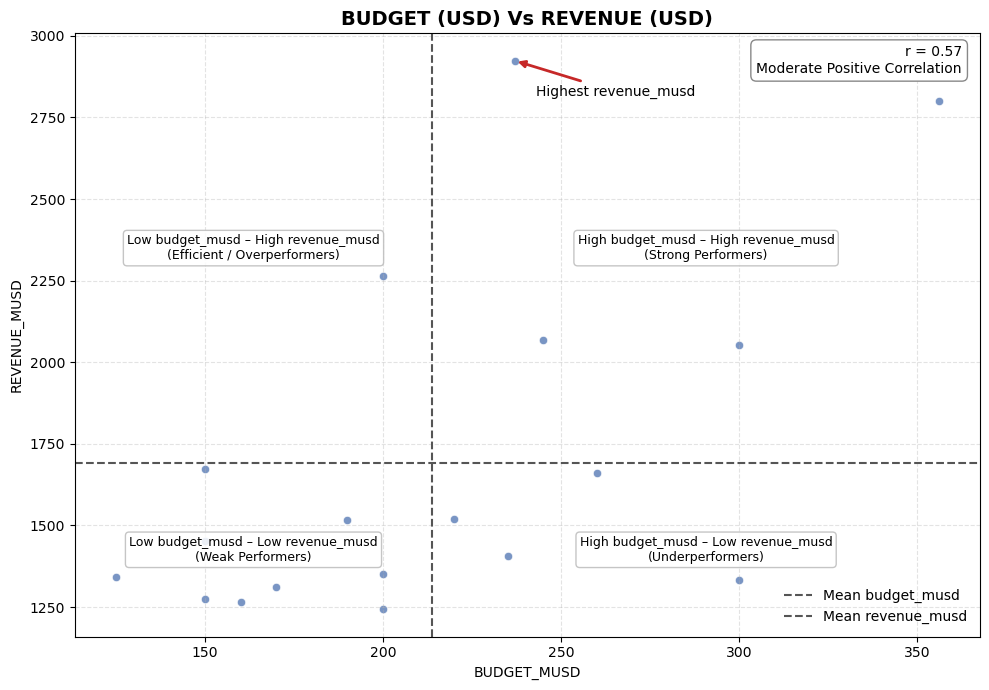

2026-01-29 08:59:33,391 - trend_visuals - INFO - Trend visualization saved to /data/visualizations/trend_budget_musd_vs_revenue_musd.png


In [39]:
#Calls the trend visuals function
trendVisuals(data=rev_budget_pdf, column1="budget_musd", column2="revenue_musd", title="BUDGET (USD) Vs REVENUE (USD)")

**Key insight**

- Higher budgets generally lead to higher revenues, but with significant exceptions.

#### **POPULARITY VS RATING**

In [40]:
#Extracts the popularity and vote average from the pyspark dataFrame and converts it to a pandas dataFrame
pop_rating_pdf = (
    cleaned_data
    .select("popularity", "vote_average")
    .filter(
        (F.col("popularity").isNotNull()) &
        (F.col("vote_average").isNotNull()) &
        (F.col("vote_count") >= 10)
    )
    .toPandas()
)


2026-01-29 08:59:33,625 - trend_visuals - INFO - Starting trend visualization: popularity vs vote_average


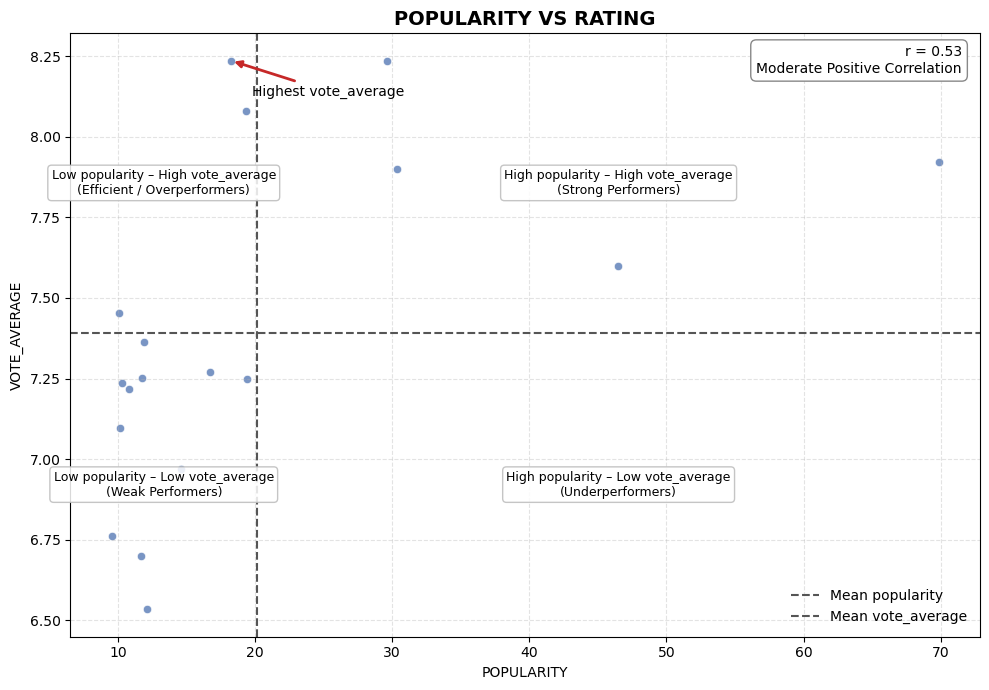

2026-01-29 08:59:34,884 - trend_visuals - INFO - Trend visualization saved to /data/visualizations/trend_popularity_vs_vote_average.png


In [41]:
#Calls the trend visuals function
trendVisuals(data=pop_rating_pdf, column1="popularity", column2="vote_average", title="POPULARITY VS RATING")

**Key insight**

- Popular movies tend to be better rated, but quality alone does not guarantee popularity.

#### **YEARLY TRENDS**

In [42]:
#Extracts the release date and revenue from sparks dataFrame and converts it to a pandas dataFrame
yearly_revenue_pdf = (
    cleaned_data
    .select("release_date", "revenue_musd")
    .filter(
        (F.col("release_date").isNotNull()) &
        (F.col("revenue_musd").isNotNull())
    )
    .toPandas()
)

2026-01-29 08:59:35,264 - yearly_box_office_trends - INFO - Starting yearly box office trend visualization


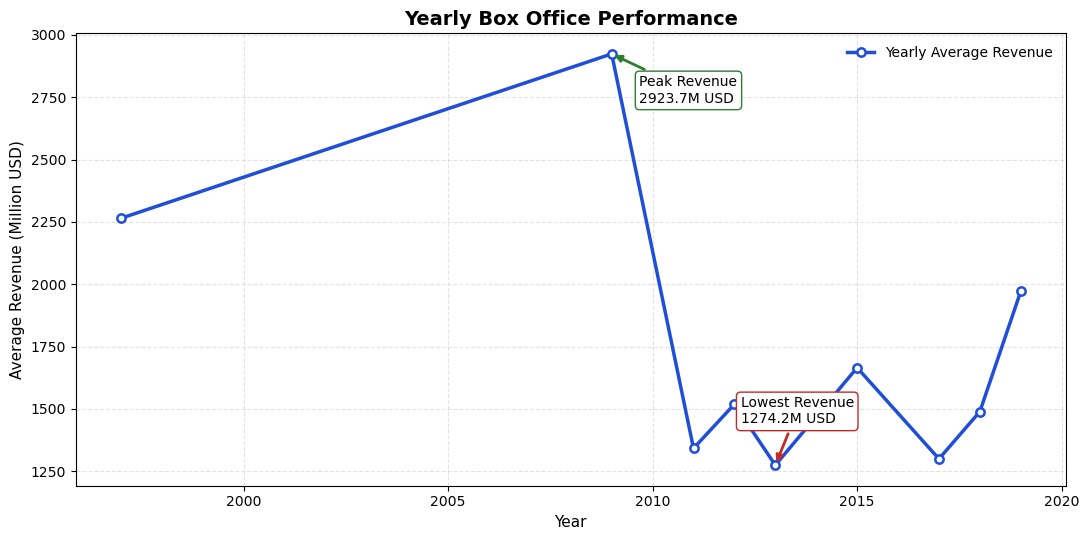

2026-01-29 08:59:36,156 - yearly_box_office_trends - INFO - Yearly box office trend saved to /data/visualizations/yearly_box_office_trends.png


In [43]:
#Calls the plot yearly trends
plot_yearly_box_office_trends(yearly_revenue_pdf)

**Key insights**

- Average revenue steadily increased from the late 1990s to 2009, peaking at approximately $2.9B.

- Sharp decline around 2011–2013

- Revenue drops dramatically, hitting the lowest point in 2013 (~$1.27B).

- Revenues fluctuate but trend upward again by 2019, showing resilience rather than collapse.

#### **FRANCHISE AND STANDALONE COMPARISON**

In [44]:
#Extracts the fields for plotting the graph
franchise_pdf = (
    performance_kpis["highest_budget"]
    .withColumn(
        "movie_type",
        F.when(F.col("belongs_to_collection").isNotNull(), "Franchise")
         .otherwise("Standalone")
    )
    .groupBy("movie_type")
    .agg(
        F.avg("revenue_musd").alias("revenue_musd"),
        F.avg("budget_musd").alias("budget_musd"),
        F.avg("vote_average").alias("vote_average"),
        F.avg("ROI").alias("ROI")
    )
    .toPandas()
)


2026-01-29 08:59:36,792 - franchise_vs_standalone - INFO - Starting franchise vs standalone visualization


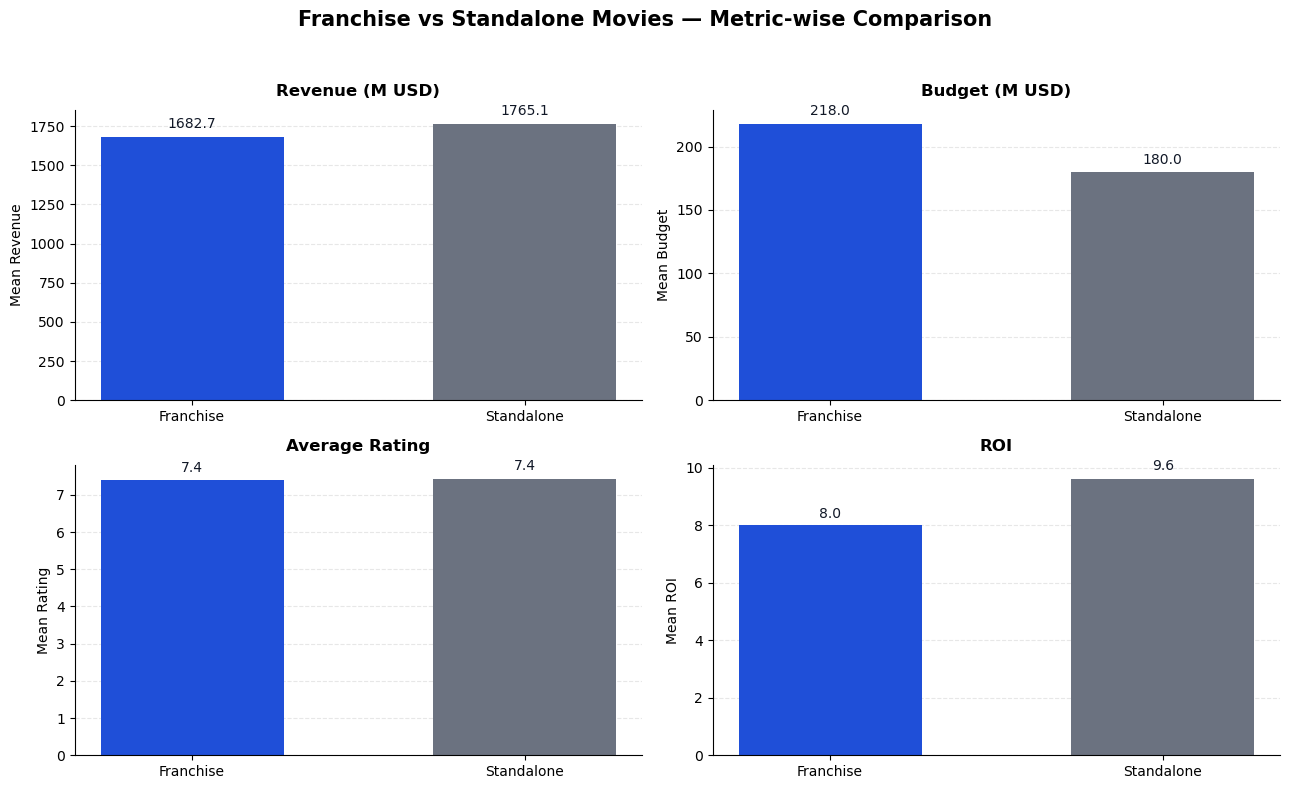

2026-01-29 08:59:38,789 - franchise_vs_standalone - INFO - Franchise vs Standalone chart saved to /data/visualizations/franchise_vs_standalone_metrics.png


In [45]:
#Calls the function to plot the graph
plot_franchise_vs_standalone_metrics(franchise_pdf)

**Key Insights**

- Standalone films actually generate slightly higher mean revenue ($1,765.1M) compared to franchise films ($1,682.7M)

- Franchise films require significantly higher budgets ($218M) compared to standalone films ($180M)
This represents about 21% more investment for franchise productions

- Standalone films deliver substantially better ROI (9.6) compared to franchise films (8.0)

- Both categories receive identical average ratings (7.4), indicating comparable audience satisfaction regardless of franchise status

### **ROI DISTRIBUTION BY GENRE**

In [46]:
#Extracts the data needed for the plotting
roi_genre = (
    performance_kpis["highest_budget"]
    .groupBy("genres")
    .agg(F.expr("percentile_approx(roi, 0.5)").alias("median_roi"))
)

# Pandas (small, safe)
roi_genre_pdf = roi_genre.toPandas()


2026-01-29 08:59:39,378 - roi_by_genre - INFO - Starting ROI by genre visualization


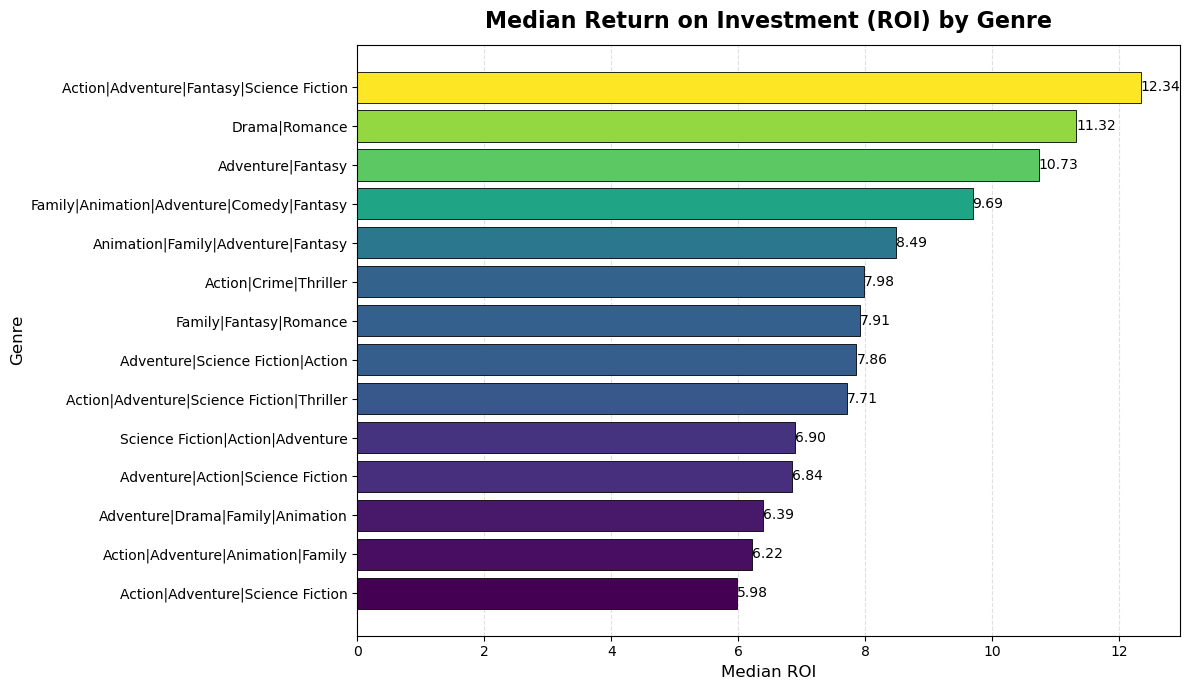

2026-01-29 08:59:40,991 - roi_by_genre - INFO - ROI by genre chart saved to /data/visualizations/median_roi_by_genre.png


In [47]:
#Calls the function
plot_roi_by_genre(roi_genre_pdf)

**Key Insights**

- Action/Adventure/Fantasy/Science Fiction leads with an impressive 12.34 median ROI

- Drama/Romance comes in second at 11.32

- Adventure/Fantasy ranks third at 10.73

- Multi-genre combinations (especially those including Action, Adventure, and Fantasy/Science Fiction) tend to perform better financially